In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.serialize import model_to_json
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


/Users/joaoandrade/.pyenv/versions/3.12.7/envs/chatbot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/combined_data.csv')
df = df.sort_index()
df.set_index('Date', inplace=True)
df['lag_weekly_sales'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(52)
df.reset_index(inplace=True)
df = df.dropna(subset=['lag_weekly_sales'])


In [3]:
store_data = df[['Date', 'Weekly_Sales', 'Size','Store', 'Dept','MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'week', 'month', 'day', 'lag_weekly_sales', 'IsHoliday']]
store_data.columns = ['ds', 'y', 'Size', 'Store', 'Dept','MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'week', 'month', 'day', 'lag_weekly_sales', 'IsHoliday'] 
regressors = ['Size','Store', 'Dept','MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'week', 'month', 'day', 'lag_weekly_sales']

In [4]:
new_years = pd.DataFrame({
'holiday': 'new_year',
'ds': pd.to_datetime(['2010-12-31', '2011-12-30']),
})
thanksgiving = pd.DataFrame({
'holiday': 'thanksgiving',
'ds': pd.to_datetime(['2010-11-26', '2011-11-25']),
'lower_window': 0,
'upper_window': 0,
})
superbowls = pd.DataFrame({
'holiday': 'superbowl',
'ds': pd.to_datetime(['2010-02-12', '2012-02-10', '2011-02-11']),
'lower_window': 0,
'upper_window': 0,
})
labor_days = pd.DataFrame({
'holiday': 'labor_day',
'ds': pd.to_datetime(['2010-09-10', '2011-09-09', '2012-09-07']),
'lower_window': 0,
'upper_window': 0,
})
holidays = pd.concat((new_years, superbowls, thanksgiving,labor_days))

In [5]:
model = Prophet(holidays=holidays, holidays_prior_scale = 50, weekly_seasonality=True)
model.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='IsHoliday')
model.add_country_holidays(country_name='US')
for regressor in regressors:
    model.add_regressor(regressor)


In [6]:
markDowns = ['MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for markdown in markDowns:
    store_data[markdown].fillna(value=store_data[markdown].mean() , inplace=True) 

/var/folders/8g/hxdrgzwn3hj4nvsz61s8r23m0000gn/T/ipykernel_63506/4080054981.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  store_data[markdown].fillna(value=store_data[markdown].mean() , inplace=True)
/var/folders/8g/hxdrgzwn3hj4nvsz61s8r23m0000gn/T/ipykernel_63506/4080054981.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_data[

In [15]:
train, test = train_test_split(store_data, test_size=0.2, random_state=42)


In [8]:
model.fit(train)


00:58:27 - cmdstanpy - INFO - Chain [1] start processing
00:59:19 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
test = test.sort_values(by='ds', ascending=True)


In [10]:
forecast = model.predict(test)


In [17]:
print(f'R2: {r2_score(test['y'], forecast['yhat'])}')
print(f'MSE : {mean_squared_error(test['y'], forecast['yhat'])}')
print(f'RMSE: {np.sqrt(mean_squared_error(test['y'], forecast['yhat']))}')


R2: 0.9637257348752604
MSE : 19115006.856285512
RMSE: 4372.071231840295


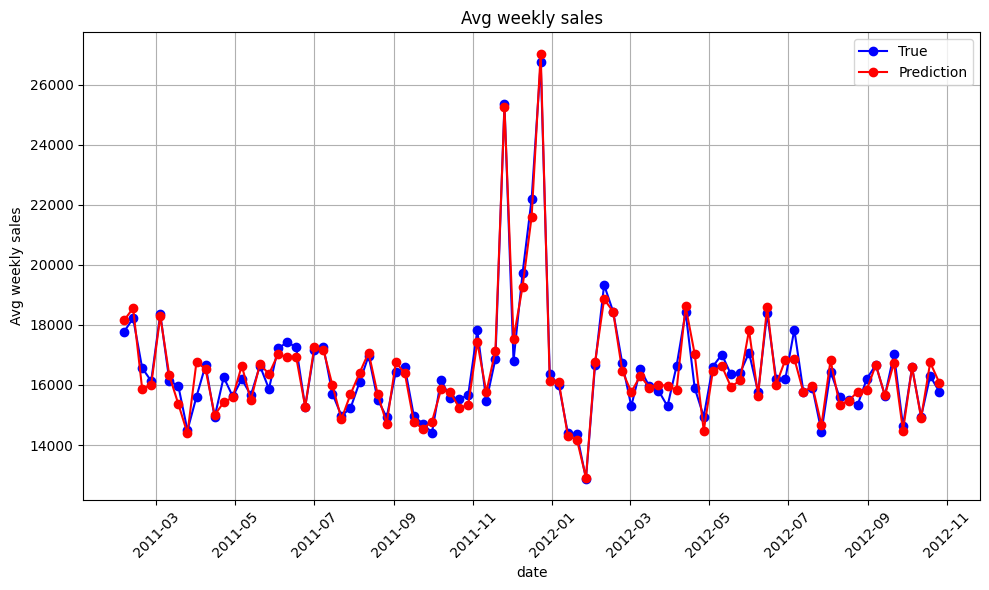

In [19]:
test['ds'] = pd.to_datetime(test['ds'])
df_grouped = test.groupby('ds', as_index=False)['y'].mean()
forecast['ds'] = pd.to_datetime(forecast['ds'])
df_forecast_grouped = forecast.groupby('ds', as_index=False)['yhat'].mean()
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['ds'], df_grouped['y'], marker='o', linestyle='-', color='b')
plt.plot(df_forecast_grouped['ds'], df_forecast_grouped['yhat'], marker='o', linestyle='-', color='r')
plt.title('Avg weekly sales')
plt.xlabel('date')
plt.ylabel('Avg weekly sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(['True', 'Prediction'])
plt.tight_layout()
plt.show()


In [27]:
single_store = store_data[(store_data['Store'] == 5) & (store_data['Dept'] == 1)]
single_store = single_store.sort_values(by='ds', ascending=True)
last_row = single_store.tail(1)
last_date = pd.to_datetime(last_row['ds'].iloc[0])
last_rows = pd.DataFrame({
    'ds': [last_date + pd.DateOffset(weeks=i) for i in range(1, 53)]
})
last_rows = last_rows.join(single_store.tail(52).reset_index(drop=True).drop(columns=['ds']))
result_df = last_rows
result_df = result_df.drop(columns=['y'])

In [28]:
predictions = model.predict(result_df)

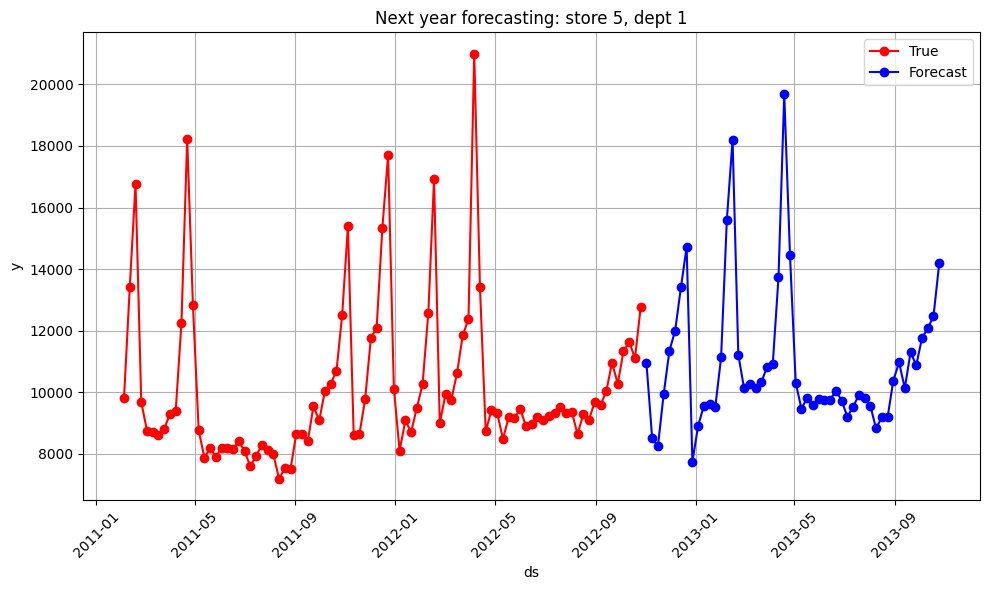

In [30]:
predictions['ds'] = pd.to_datetime(predictions['ds'])
single_store['ds'] = pd.to_datetime(single_store['ds'])
plt.figure(figsize=(10, 6))
plt.plot(single_store['ds'], single_store['y'], marker='o', linestyle='-', color='r')
plt.plot(predictions['ds'], predictions['yhat'], marker='o', linestyle='-', color='b')
plt.title('Next year forecasting: store 5, dept 1')
plt.xlabel('ds')
plt.ylabel('y')
plt.grid(True)
plt.legend(['True', 'Forecast'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
regressor_coef = regressor_coefficients(model)
regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef')

,regressor,regressor_mode,coef
8,week,additive,-105.340525
1,Store,additive,-4.026345
3,MarkDown1,additive,-0.014106
0,Size,additive,0.001797
5,MarkDown3,additive,0.002382
6,MarkDown4,additive,0.011070
4,MarkDown2,additive,0.022294
7,MarkDown5,additive,0.030865
11,lag_weekly_sales,additive,0.988909
2,Dept,additive,11.085666


In [41]:
store_dept_combinations = store_data[['Store', 'Dept']].drop_duplicates()
for _, row in store_dept_combinations.iterrows():
    store, dept = row['Store'], row['Dept']
    single_store = store_data[(store_data['Store'] == store) & (store_data['Dept'] == dept)]
    single_store = single_store.sort_values(by='ds', ascending=True)
    last_row = single_store.tail(1)
    last_date = pd.to_datetime(last_row['ds'].iloc[0])
    last_52_rows = single_store.tail(52).reset_index(drop=True)
    future_rows = pd.DataFrame({
        'ds': [last_date + pd.DateOffset(weeks=i) for i in range(1, 53)]
    })
    
    future_rows = future_rows.join(last_52_rows.drop(columns=['ds']))
    future_rows['lag_weekly_sales'] = future_rows['y']
    future_rows = future_rows.drop(columns=['y'])
    result_df = pd.concat([result_df, future_rows], ignore_index=True)

In [42]:
result_df = result_df.dropna()

In [43]:
result_df = result_df.sort_values(by='ds', ascending=True)


In [44]:
result_df

,ds,Size,Store,Dept,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,week,month,day,lag_weekly_sales,IsHoliday
0,2011-07-01,158114.0,34.0,58.0,7289.011106,3333.962001,1422.492,3385.573306,4647.335923,8.0,2.0,25.0,1919.97,False
295942,2011-07-01,158114.0,34.0,58.0,7289.011106,3333.962001,1422.492,3385.573306,4647.335923,8.0,2.0,25.0,2485.00,False
295943,2011-07-08,158114.0,34.0,58.0,7289.011106,3333.962001,1422.492,3385.573306,4647.335923,9.0,3.0,4.0,3260.00,False
1,2011-07-08,158114.0,34.0,58.0,7289.011106,3333.962001,1422.492,3385.573306,4647.335923,9.0,3.0,4.0,1350.00,False
2,2011-07-15,158114.0,34.0,58.0,7289.011106,3333.962001,1422.492,3385.573306,4647.335923,10.0,3.0,11.0,2234.97,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151057,2013-10-25,203007.0,32.0,30.0,8968.720000,104.910000,200.000,534.860000,1821.850000,43.0,10.0,26.0,1792.74,False
151056,2013-10-25,203819.0,24.0,26.0,10844.380000,104.160000,105.090,1795.680000,3059.800000,43.0,10.0,26.0,9554.66,False
151055,2013-10-25,206302.0,28.0,6.0,6490.130000,90.020000,1422.492,1750.840000,1684.360000,43.0,10.0,26.0,4406.39,False
150946,2013-10-25,42988.0,30.0,80.0,150.460000,1.750000,1422.492,3385.573306,367.830000,43.0,10.0,26.0,6954.65,False


In [54]:
next_year_pred  = model.predict(result_df)

In [55]:
next_year_pred["Store"] = result_df['Store']
next_year_pred["Dept"] = result_df['Dept']
next_year_pred = next_year_pred[['ds','Store', 'Dept', 'yhat']].copy()
next_year_pred.columns = ['date','Store', 'Dept', 'prediction']

In [56]:
next_year_pred

,date,Store,Dept,prediction
0,2011-07-01,34.0,58.0,2575.889587
1,2011-07-01,34.0,58.0,3134.652961
2,2011-07-08,34.0,58.0,3892.868084
3,2011-07-08,34.0,58.0,2004.051481
4,2011-07-15,34.0,58.0,2955.978385
...,...,...,...,...
304787,2013-10-25,3.0,51.0,4040.571494
304788,2013-10-25,3.0,51.0,11731.196707
304789,2013-10-25,3.0,51.0,6427.964580
304790,2013-10-25,3.0,51.0,9531.746192


In [71]:
df_cv = cross_validation(model, initial='365 days', period='15 days', horizon = '180 days')
df_p = performance_metrics(df_cv)


  0%|          | 0/6 [00:00<?, ?it/s]13:23:37 - cmdstanpy - INFO - Chain [1] start processing
13:24:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:42<03:34, 42.93s/it]13:24:20 - cmdstanpy - INFO - Chain [1] start processing
13:24:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [01:28<02:57, 44.30s/it]13:25:06 - cmdstanpy - INFO - Chain [1] start processing
13:25:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [02:10<02:10, 43.36s/it]13:25:48 - cmdstanpy - INFO - Chain [1] start processing
13:26:29 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [03:08<01:38, 49.30s/it]13:26:47 - cmdstanpy - INFO - Chain [1] start processing
13:27:40 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [04:19<00:56, 56.87s/it]13:27:57 - cmdstanpy - INFO - Chain [1] start processing
13:28:39 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [05:19<00:00, 53.22s/it]


In [66]:
df_p

,horizon,mse,rmse,mae,mdape,smape,coverage
0,19 days,1.102605e+09,33205.492382,13969.810834,0.220859,0.591072,0.792061
1,20 days,1.654641e+09,40677.275214,19816.141030,0.264767,0.695852,0.731966
2,21 days,1.656931e+09,40705.419961,19836.352373,0.270865,0.694091,0.732606
3,22 days,1.660423e+09,40748.294356,19938.246800,0.269151,0.690133,0.729861
4,23 days,1.331526e+09,36490.086323,16427.627616,0.237258,0.626542,0.765838
...,...,...,...,...,...,...,...
134,175 days,2.727121e+09,52221.844391,31883.946980,0.955899,1.064933,0.669940
135,176 days,3.174575e+09,56343.366626,36990.980586,1.448027,1.151423,0.607256
136,177 days,2.779238e+09,52718.476042,32971.379750,1.042662,1.081079,0.649711
137,179 days,2.587035e+09,50862.907165,31272.735801,1.007085,1.096495,0.671017


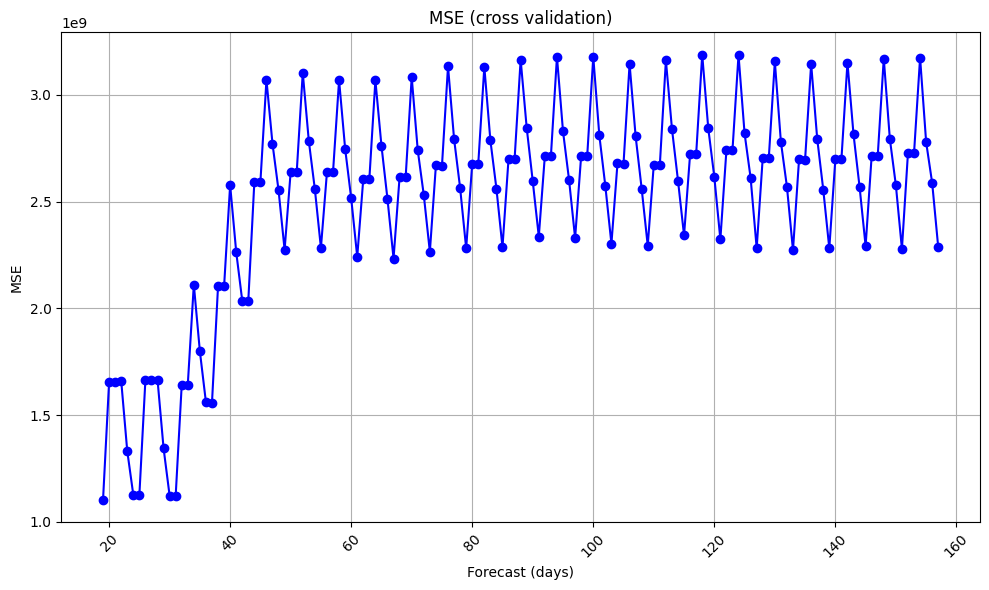

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(df_p.index +19, df_p['mse'], marker='o', linestyle='-', color='b')
plt.title('MSE (cross validation)')
plt.xlabel('Forecast (days)')
plt.ylabel('MSE')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
with open('../src/models/prophet_1_year.json', 'w') as fout:
    fout.write(model_to_json(model))  
